# Opening and processing kwik files

Importing

In [7]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle

if "__file__" not in dir():
    root="C:\\data"

def find_file(path, extension=['.raw.kwd']):
    """
    This function finds all the file types specified by 'extension' (ex: *.dat) in the 'path' directory
    and all its subdirectories and their sub-subdirectories etc., 
    and returns a list of all dat file paths
    'extension' is a list of desired file extensions: ['.dat','.prm']
    """
    if type(extension) is str:
        extension=extension.split()   #turning extension into a list with a single element
    return [os.path.join(walking[0],goodfile) for walking in list(os.walk(path)) 
         for goodfile in walking[2] for ext in extension if goodfile.endswith(ext)]

def prm_reader(prmFile):
    CWD=os.getcwd()
    try:
        os.chdir(os.path.dirname(prmFile))
        prmName=os.path.basename(prmFile)
        %run $prmName
    finally:
        os.chdir(CWD)
    return globals()

## Opening the KWIK file

Opening a KWIK file and returning the spike information

In [2]:
def read_spikes_sample_and_clu(session):
    #cluGroup is the group of the cluster (noise, mua, good...)
    spikeSample,clusterGroup={},{}
    spikeIndex={}
    channelGroupList = {}
    first = True
    for chgroup in session.model.channel_groups:
        if first:
            first = False
        else:
            session.change_channel_group(chgroup)
        spikeSample[chgroup]={}
        clusterGroup[chgroup]={}
        spikeIndex[chgroup]={}
        #self.channelGroupList[chgroup] = list(session.model.channel_order)
        #default cluster group names (0: 'Noise', 1: 'MUA', 2: 'Good', 3: 'Unsorted')
        for cluGroupName in session.model.default_cluster_groups.values():
            clusterGroup[chgroup][cluGroupName]=[]
            
        #for every cluster in the channel_group
        for clu in session.model.cluster_ids:
            spikeSample[chgroup][clu]=session.model.spike_samples[session.model.spike_clusters==clu]  
            #spikeIndex[chgroup][clu]=session.model.spike_ids[session.model.spike_clusters==clu]
            cluGroupID=session.model.cluster_metadata.group(clu)
            if isinstance(cluGroupID, np.ndarray):
                print("Warning- cluster group of cluster %s is an array (%s), taking first value"%(clu,cluGroupID))
                cluGroupID=cluGroupID[0]
            if isinstance(cluGroupID, bytes):
                print("Warning- cluster group of cluster %s is a bytes, putting it in 'unsorted'"%(clu))
                cluGroupID = 3
            # if a group was created (ID>3), put it in "Good"(2)
            if cluGroupID>3:
                cluGroupID=2
            cluGroupName=session.model.default_cluster_groups[cluGroupID]        
            clusterGroup[chgroup][cluGroupName].append(clu)
    #self.spikeIndex=spikeIndex
    return spikeSample,clusterGroup

def open_kwik_file(inputFile):
    """
    This function opens a kwik file using KWIKphy session package, 
    and returns spike times and types of Good and MUA clusters
    """
    if not os.path.exists(inputFile):
        print("%s\nKWIK file not found!"%(inputFile))
        return False
    from KWIKphy.session import Session
        
    try:
        sessionInfo=Session(inputFile)
        print("KWIK file loaded!")
    except Exception as e:
        print("KWIKphy failed to open the KWIK file:")
        print(inputFile)
        print(repr(e))
        return False
    
    spikeSample,clusterGroup=read_spikes_sample_and_clu(sessionInfo)
    print("Done!")
    return spikeSample,clusterGroup



#----------------------------------------------------------------
if "__file__" not in dir():
   
    inputFile="C:\\data\\SWI016\\Experiments\\SWI016_2017_02_03_14_03\\SWI016_2017_02_03_14_03.kwik"
    a=open_kwik_file(inputFile)
    #print(a)

C:\data\SWI016\Experiments\SWI016_2017_02_03_14_03\SWI016_2017_02_03_14_03.kwik
KWIK file not found!


## Processing

Features and masks initialized.
Initializing statistics: 100.0%.
Statistics initialized.
Initializing statistics: 100.0%.
KWIK file loaded!
Done!


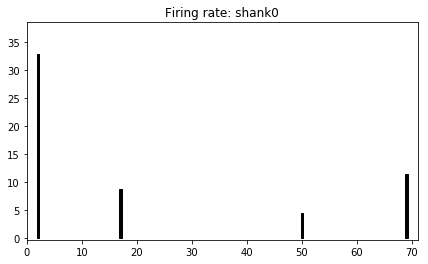

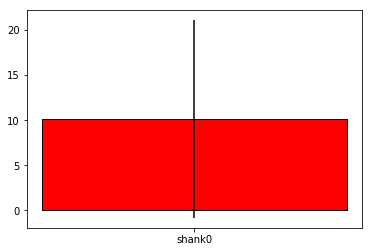

In [3]:
def compute_firing_rate(data):
    """
    This functions computes firing rate of a SINGLE neuron
    data: spike times as a np.array vector
    output: 
    """
    ISI=np.diff(data) #ISI means Inter Spike Interval
    return np.median (np.reciprocal(ISI.astype('float')))

def plot_median_firing_rate(spikeSample,clusterGroup,samplingRate,
                            cluToPlot=['Good']):
        
    if type(cluToPlot) is str:
        cluToPlot=cluToPlot.split()    #turns into a list
   
    #max number of neurons per shank
    maxN=0
    for shank in spikeSample:
        if len(spikeSample[shank].keys()) > maxN:
            maxN=len(spikeSample[shank].keys())
    
    #create an empty 3D matrix with Nan values
    neuralFiringRate=np.empty((len(cluToPlot),
                               len(spikeSample),
                               maxN))*np.nan
    
    #then fill matrix with values : neuralFiringRate=cluType*shank*cluster 
    for cluType in cluToPlot:
        for shank in spikeSample: #1st fig for shank0 and 2nd for shank1
            fig, ax = plt.subplots(figsize=(7,4))
            for clu in clusterGroup[shank][cluType]:
                tmp=compute_firing_rate(spikeSample[shank][clu]/samplingRate)
                neuralFiringRate[cluToPlot.index(cluType),shank,clusterGroup[shank][cluType].index(clu)]=tmp
                plt.bar(clu, tmp, ecolor='k', align='center', width=0.5, edgecolor='k', color='k')
                plt.xlim(0,maxN+1)
                plt.ylim(-.3,plt.ylim()[1]+1)
                plt.title("Firing rate: shank"+str(shank))
                
    #Plotting
    Median={}
    Std={}
    for cluType in cluToPlot:
        plt.figure()
        Median[cluType]=[]
        Std[cluType]=[]
        for ID,shank in enumerate(spikeSample):
            Median[cluType].append(np.nanmedian(neuralFiringRate[cluToPlot.index(cluType),shank,:]))
            Std[cluType].append(np.nanstd(neuralFiringRate[cluToPlot.index(cluType),shank,:]))
            plt.bar(left=shank,
                    height=Median[cluType][-1],
                    yerr=Std[cluType][-1],
                    color='r',
                    edgecolor='k',
                    ecolor='k')
        Median[cluType]=[np.nanmean(Median[cluType])]

        plt.xticks([i for i in spikeSample.keys()],['shank'+str(i) for i in spikeSample.keys()])
        plt.show()

    return neuralFiringRate

#---------------------------------------------------------
if "__file__" not in dir():
    path="/data/SWI002/2/SWI002_2016_09_20_12_31/SWI002_2016_09_20_12_31.kwik"
    spikeSample,clusterGroup=open_kwik_file(path)
    a=plot_median_firing_rate(spikeSample,clusterGroup,20000,['Good'])

### run for all the sessions of an animal

In [ ]:
def animal_firing_rate(root,animal,cluToPlot=['Good'],overwrite=False):
    
    kwikFileList=find_file(os.path.join(root,animal), extension=['.kwik'])
    for kwikFile in kwikFileList:
        picklePath=os.path.join(os.path.dirname(kwikFile),'FiringRate_'+str(cluToPlot)+'.p')
        if os.path.isfile(picklePath) and not overwrite:
            continue
        session=os.path.basename(kwikFile).split('.')[0]
        prmFile=os.path.join(os.path.dirname(kwikFile),session+'.prm')
        samplingRate=prm_reader(prmFile)['sample_rate']
        spikeSample,clusterGroup=open_kwik_file(kwikFile)
        firingRate=plot_median_firing_rate(spikeSample,clusterGroup,samplingRate,cluToPlot=cluToPlot)
        plt.close()
        with open(picklePath,'wb') as f:
            pickle.dump(firingRate,f)
    print('pickles are ready!')
    
def animal_grand_average(root,animal,cluToPlot=['Good'],redoPickle=False):
    
    animal_firing_rate(root,animal,cluToPlot=cluToPlot,overwrite=redoPickle)
    pickleName='FiringRate_'+str(cluToPlot)+'.p'
    pFileList=find_file(os.path.join(root,animal), extension=['.p'])
    results=[]
    for pickcleFile in pFileList:
        if pickleName not in pickleFile:
            continue
        with open(pickleFile,'rb') as f:
            results.append(pickle.load(f))
    values=[]
    for item in results:
        values.extend(item.flatten().tolist())
    
    return np.nanmedian (values)

In [ ]:
    for animal in animalList:
        animalFolder=os.path.join(path,animal)
        rawfile_list = find_file(animalFolder,['.raw.kwd'])
        for rawfile in rawfile_list:
            try:
                conversion_result= convert_kwd_to_dat(rawfile,overwrite=overwrite)
                if isinstance(conversion_result,bool):
                    print(".raw.kwd to .dat conversion failed:%s"%(rawfile))
                else:
                    nchannels, sampling_rate=conversion_result
                    experiment=os.path.splitext(os.path.splitext(os.path.split(rawfile)[1])[0])[0]
                    save_prm_file(os.path.split(rawfile)[0],experiment,sampling_rate,nchannels,overwrite=True)
                    if saveEEG:
                        create_eeg(rawfile,downsample=int(sampling_rate/1250),
                                   inputSamplingRate=sampling_rate)
